# Assembling Stiffness matrix; Impose Boundary conditions; Solve

This workflow can be extended to any geometry.

Content:
* [Create, refine and assign topology to geometry](#geometry)
* [Build stiffness matrix](#k)
* [Assign Dirichlet Boundary Conditions](#bc)
* [Solving system of equations](#solve)
* [Post-processing](#post)
    * [plot](#plot)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<a id='geometry'></a>
## 1) Create geometry - Anticline model; refine and assign topology

In [2]:
from pygeoiga.nurb.nurb_creation import NURB

In [3]:
# Create multipatch structure
cp1 = np.array([[[0., 0.], [0.,  50.], [0., 100.]],
                [[250., 0.], [250., 180.], [250., 250.]],
                [[500.,   0.], [500.,  50.], [500., 100.]]])
knot1 = [[0, 0, 0, 1, 1, 1],[0, 0, 0, 1, 1, 1]]

nrb1 = NURB(cp1, knot1)
cp2=np.array([[[0., 100.], [0., 200.], [0., 300.]],
                       [[250., 250.], [250., 350.], [250., 400.]],
                       [[500., 100.], [500., 200.], [500., 300.]]])
knot2= [[0, 0, 0, 1, 1, 1],[0, 0, 0, 1, 1, 1]]
nrb2 = NURB(cp2, knot2)

cp3 = np.array([[[0., 300.], [0., 400.], [0., 500.]],
                        [[250., 400.], [250., 450.], [250., 500.]],
                        [[500., 300.], [500., 400.], [500., 500.]]])
knot3 = [[0, 0, 0, 1, 1, 1],[0, 0, 0, 1, 1, 1]]

nrb3 = NURB(cp3, knot3)

In [4]:
from pygeoiga.nurb.multipatch_NURBS import Multipatch

In [5]:
mult = Multipatch()
# Kappa is the thermal conductivity of the patch
mult.add_patch(nrb1, "Bottom", position=(1,1), kappa = 2, color="red")
mult.add_patch(nrb2, "Middle", position=(2,1), kappa = 3.1, color="green")
mult.add_patch(nrb3, "Top", position=(3,1), kappa = 0.8, color="blue")

In [6]:
knot_ins = np.arange(0.1, 1, 0.1)

mult.global_knot_insertion(knot_ins, direction =0)
mult.global_knot_insertion(knot_ins, direction =1)

True

In [7]:
# Assign connection between faces
mult.define_topology()

True

In [8]:
gDoF = mult.fill_topological_info()
print("Global degrees of freedom: ", gDoF)

Global degrees of freedom:  408


<a id='k'></a>
## 2) Assemble stiffness matrix

In [9]:
# Set empty the stiffness matrix
K = np.zeros((gDoF, gDoF))

In [10]:
# Assemble stiffnes matrix
from pygeoiga.analysis.MultiPatch import form_k_IGA_mp

In [11]:
# Depending to the degrees of freedoms this can take a while
K = form_k_IGA_mp(mult.geometry, K)

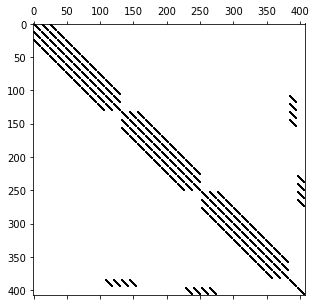

In [12]:
# Plot the stiffness matrix shape
fig, ax = plt.subplots(figsize=(5,5))
ax.spy(K)

<a id='bc'></a>
## 3) Assign Boundary conditions

In [13]:
f = np.zeros(gDoF) # Force vector
a = np.zeros(gDoF) # Solution vector

In [14]:
T_t = 10  # [°C]
T_b = 25  # [°C]
T_l = None  # 10
T_r = None  # 40

In [15]:
from pygeoiga.analysis.MultiPatch import boundary_condition_mp
bc, a = boundary_condition_mp(mult.geometry, a, T_t, T_b, T_l, T_r)
bc["gDOF"] = gDoF

<a id='solve'></a>
## 4) Solve:  Ka = f


In [16]:
from pygeoiga.analysis.common import solve

In [17]:
a, f = solve(bc, K, f, a)

In [18]:
# Temperatures
a[:10]

array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25.])

<a id='post'></a>
## 5) Post-processing

In [19]:
from pygeoiga.analysis.MultiPatch import map_MP_elements
# Map solution to geometry
mult.geometry = map_MP_elements(mult.geometry, a)

<a id='plot'></a>
### Plotting

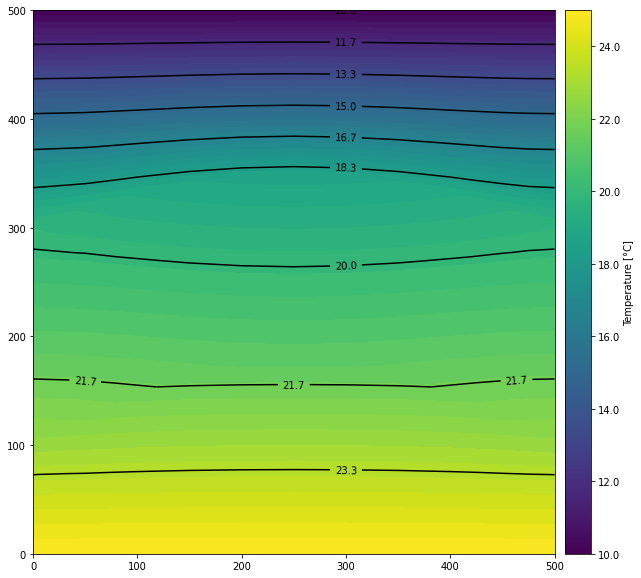

In [20]:
from pygeoiga.plot.solution_mpl import p_temperature
fig, ax = plt.subplots(figsize=(10,10))
for patch_id in mult.geometry.keys():
    x = mult.geometry[patch_id].get("x_sol")
    y = mult.geometry[patch_id].get("y_sol")
    t = mult.geometry[patch_id].get("t_sol")
    ax = p_temperature(x,
                       y,
                       t, 
                       vmin = np.min(a), 
                       vmax = np.max(a), 
                       levels=50, 
                       show=False, 
                       colorbar=True, 
                       ax=ax,
                       point = False, 
                       fill=True, 
                       contour=False)
    ax = p_temperature(x,
                       y,
                       t, 
                       vmin = np.min(a), 
                       vmax = np.max(a), 
                       levels=10, 
                       show=False, 
                       colorbar=True, 
                       ax=ax,
                       point = False, 
                       fill=False, 
                       contour=True)
        

Optionally you can use the solution plotting

<AxesSubplot:>

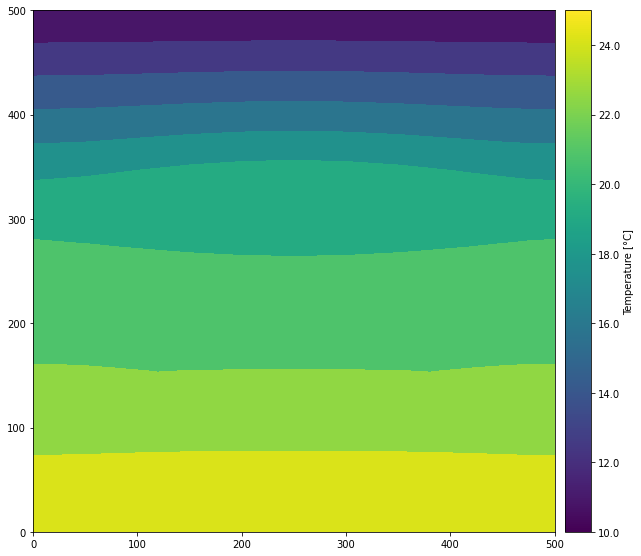

In [21]:
mult.plot_solution()